In [72]:
import random
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

In [73]:
colors_blindness = sns.color_palette("colorblind")

# Création des données

On démarre par créer des données homo et hétéro scédastiques. On crée aussi les vraies données.

In [74]:
np.random.seed(43)

n = 300
X = np.random.uniform(low=0,high=5,size=n)
sigma = 1

## Homoscedastic model
Y_hom = np.cos(X) + sigma*np.random.normal(size=n)

y_true = np.cos(np.linspace(0,5,300))

## Heteroscedastic model
y = np.cos(X) + (1-np.cos(X))*sigma*np.random.normal(size=n)



color_train = colors_blindness[1]
color_true = colors_blindness[4]
color_cal = colors_blindness[9]
color_test = colors_blindness[7]

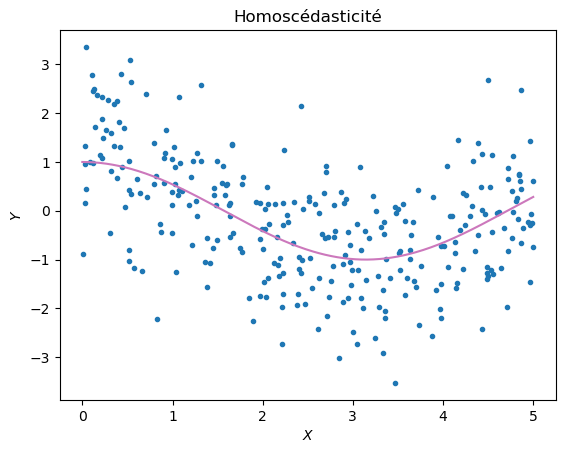

In [75]:
plt.scatter(X,Y_hom,marker='.')
plt.plot(np.linspace(0,5,300),y_true, color = color_true)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('Homoscédasticité')
plt.show()

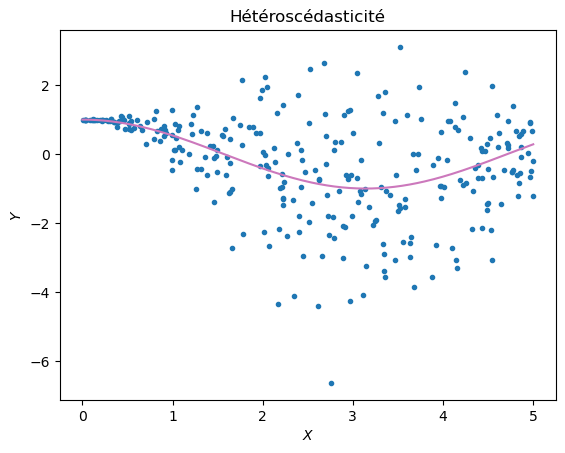

In [76]:
plt.scatter(X,y,marker='.')
plt.plot(np.linspace(0,5,300),y_true, color = color_true)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('Hétéroscédasticité')
plt.show()

# Préparation des modèles

On sépare nos données en train/test, puis on configure la régression polynomiales en créant le tableau de variables $(1,X,X^2,X^3)$. L'objectif ici est de créer une régression polynomiale médiane ( régression quantile avec $\tau =0.5$) au lieu d'une régression polynomiale classique. Nous allons créer un ensemble de prédiction conforme à partir de ce modèle.

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)

In [78]:
# Data preparation (embedding)

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(4)
Xpoly_train =  poly.fit_transform(X_train[:, np.newaxis]) # TODO OPERAND
Xpoly_test  =  poly.fit_transform(X_test[:, np.newaxis])   # TODO OPERAND

In [79]:
poly.fit_transform(np.array([5]).reshape([1,1]))

array([[  1.,   5.,  25., 125., 625.]])

# Regression quantile

Pour rappel, la régression quantile fitte un modèle linéaire sur la fonction quantile d'ordre $\tau$.
Ici, nous ne faisons pas un intervalle de prédiction avec la régression quantile:

- Nous allons créer un modèle de prédiction à l'aide d'une régression médiane
- L'intervalle de prédiction sera créé à l'aide d'une prédiction conforme.


In [80]:
from sklearn.linear_model import QuantileRegressor

from sklearn.utils.fixes import sp_version, parse_version

## a good idea is to update scipy (!) to avoid problem of convergence
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

qr_med = QuantileRegressor(quantile=0.5, alpha=0,solver='highs')

qr_med.fit(Xpoly_train, y_train)  #TODO LINE

qr_med.predict(Xpoly_test).shape

(99,)

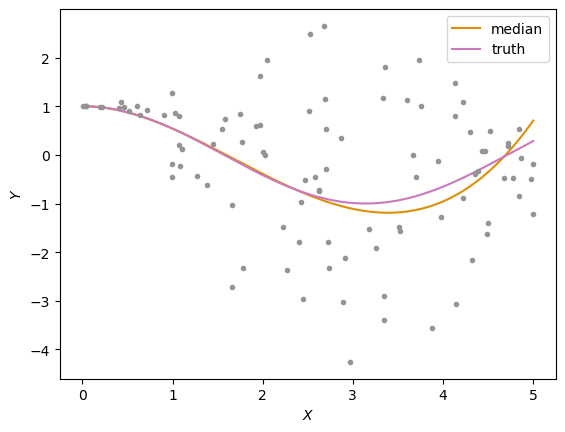

In [81]:
aux = poly.fit_transform(np.linspace(0,5,300)[:,np.newaxis])
plt.plot(np.linspace(0,5,300),qr_med.predict(aux),'-',color=color_train,label="median")
plt.plot(np.linspace(0,5,300),y_true, color = color_true,label = "truth")

plt.scatter(X_test,y_test,marker='.',color=color_test,zorder=2)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.legend()
#plt.savefig('quantile_reg.pdf', bbox_inches='tight',dpi=300)
plt.show()

# Prédiction conforme

Nous allons utiliser un algorithme CV+ dans notre cas. Pour cela, on utilise la fonction KFold de scikit-learn. 

Remarque: Un KFold où le nombre de split est égal au nombre de données est exactement un Jackknife. Si le nombre de split est égal à 1, nous revenons à une Split Conformal Prediction

In [82]:
n_splits = 10
folder = KFold(n_splits = n_splits)

In [83]:
F = folder.get_n_splits(X)

In [140]:
def score(model, x_new, x_cal,y_cal):
    score_plus = model.predict(x_new)+np.abs(y_cal-model.predict(x_cal))
    score_moins = model.predict(x_new)-np.abs(y_cal-model.predict(x_cal))
    return np.array([score_moins, score_plus]).reshape([len(y_cal),2])


In [117]:
def pred_conf(x_new,X,Y,KFolder,alpha):
    qr_med = QuantileRegressor(quantile=0.5, alpha=0,solver='highs')
    scores = np.empty([len(X),2])
    j=0
    for i, (train_set,cal_set) in enumerate(KFolder.split(X)):
        poly_train =  poly.fit_transform(X[train_set, np.newaxis])
        poly_cal = poly.fit_transform(X[cal_set, np.newaxis])
        poly_new = poly.fit_transform(np.array([x_new]).reshape([1,1]))
        model = qr_med.fit(poly_train,Y[train_set])
        scores[j:j+len(cal_set)] = score(model,poly_new,poly_cal,Y[cal_set])
        j += len(cal_set)
    return np.quantile(scores[:,0],q = alpha/2), np.quantile(scores[:,1],q = 1-alpha/2)

In [86]:
def create_up_low_bounds(X,Y,n_splits,n_steps,alpha):
    x_low = np.min(X)
    x_up = np.max(X)
    x_new = np.linspace(x_low,x_up,n_steps)
    bounds = np.empty([n_steps,2])
    KFolder = KFold(n_splits = n_splits)
    for i in range(len(x_new)):
        bounds[i] = pred_conf(x_new[i],X,Y,KFolder,alpha)
    return bounds

In [87]:
bounds = create_up_low_bounds(X_train,y_train,n_splits = 5,n_steps = 100, alpha = 0.1)

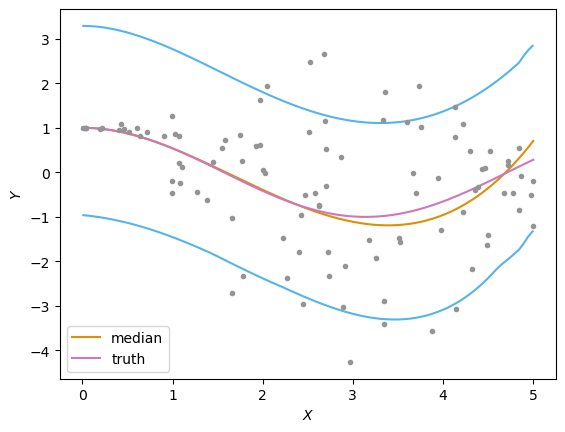

In [88]:
aux = poly.fit_transform(np.linspace(0,5,300)[:,np.newaxis])
plt.plot(np.linspace(0,5,300),qr_med.predict(aux),'-',color=color_train,label="median")
plt.plot(np.linspace(0,5,300),y_true, color = color_true,label = "truth")
plt.plot(np.linspace(np.min(X),np.max(X),100),bounds[:,0],color = color_cal)
plt.plot(np.linspace(np.min(X),np.max(X),100),bounds[:,1],color = color_cal)
plt.scatter(X_test,y_test,marker='.',color=color_test,zorder=2)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.legend()
#plt.savefig('quantile_reg.pdf', bbox_inches='tight',dpi=300)
plt.show()

# Scaled Score Function

Dans cette partie, on s'intéresse à prendre en compte l'hétéroscédasticité des données.
Comme on peut le voir, la méthode actuelle ne fait pas vraiment le boulor comme on le voudrait. Nous allons pour cela inclure une notion de variance conditionnelle autour de $X$ pour être au maximum adaptatif. Nous procédons comme suit:

- Premièrement, nous créeons une fonction $u$ assez heuristiquement et empirique. Cette fonction $u$ est censée approcher l'écart-type conditionnel: $\sqrt{(Var(Y|X=x))}$. Dans ce but, $u$ calcule l'écart-type des $Y$ correspondant aux $X$ contenu dans l'intervalle $]x-\varepsilon,x+\varepsilon[$. 

- Deuxièmement, on calcule le score dépendant de $u$. Attention: dans les scores du Jackknife et du CV+, il faut diviser la partie $|\hat{F}_{-k}(x_{i_k})-y_{i_k}|$ par $u(x_i)$ pour normaliser le score, puis re-multiplier cette partie par $u(x_{new})$ pour rescaler à l'échelle de la nouvelle donnée.

In [174]:
def u(x,amp,X,Y):
    idx = (x-amp<X)&(X<x+amp)
    y_cond = Y[idx]
    return np.std(y_cond)
def scoreu(model, x_new, x_cal, y_cal, amp):
    u_x_new = u(x_new,amp,x_cal,y_cal)
    poly_cal = poly.fit_transform(x_cal[:, np.newaxis])
    poly_new = poly.fit_transform(np.array([x_new]).reshape([1,1]))
    scores = np.empty([len(y_cal),2])
    
    for i in range(len(x_cal)):
        u_x_cal = u(x_cal[i],amp,x_cal,y_cal)
        scores[i,1] = model.predict(poly_new)+np.abs(y_cal[i]-model.predict(poly_cal[i:i+1,:]))/u_x_cal*u_x_new
        scores[i,0] = model.predict(poly_new)-np.abs(y_cal[i]-model.predict(poly_cal[i:i+1,:]))/u_x_cal*u_x_new
    return scores

def pred_conf_u(x_new,X,Y,KFolder,alpha,amp):
    qr_med = QuantileRegressor(quantile=0.5, alpha=0,solver='highs')
    n = len(X)
    scores = np.empty([len(X),2])
    j=0
    for i, (train_set,cal_set) in enumerate(KFolder.split(X)):
        poly_train =  poly.fit_transform(X[train_set, np.newaxis])
        model = qr_med.fit(poly_train,Y[train_set])
        scores[j:j+len(cal_set)] = scoreu(model,x_new,X[cal_set],Y[cal_set],amp)
        j += len(cal_set)
    return np.quantile(scores[:,0],q = (alpha/2)*n/(n+1)), np.quantile(scores[:,1],q = 1-alpha/2)

def create_up_low_bounds_u(X,Y,n_splits,alpha,x_new = np.linspace(np.min(X),np.max(X),100)):
    x_low = np.min(X)
    x_up = np.max(X)
    bounds = np.empty([len(x_new),2])
    KFolder = KFold(n_splits = n_splits)
    for i in range(len(x_new)):
        bounds[i] = pred_conf_u(x_new[i],X,Y,KFolder,alpha,amp)
    return bounds

In [175]:
amp = 0.5

bounds = create_up_low_bounds_u(X_train,y_train,n_splits = 5, alpha = 0.1,x_new = X_test)



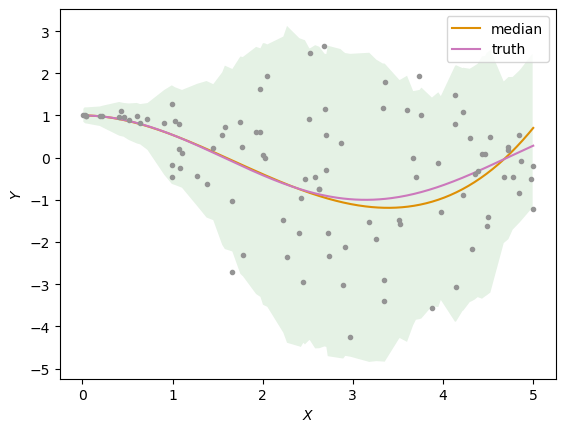

In [176]:
idx = np.argsort(X_test)
X_ax = X_test[idx]
sort_bounds = bounds[idx,:]

aux = poly.fit_transform(np.linspace(0,5,300)[:,np.newaxis])
plt.figure()

plt.plot(np.linspace(0,5,300),qr_med.predict(aux),'-',color=color_train,label="median")
plt.plot(np.linspace(0,5,300),y_true, color = color_true,label = "truth")
#plt.plot(X_test,bounds[:,0],color = color_cal)
#plt.plot(X_test,bounds[:,1],color = color_cal)
plt.fill_between(X_ax, sort_bounds[:,1], sort_bounds[:,0], where=sort_bounds[:,1] >= sort_bounds[:,0], facecolor='green', interpolate=True, alpha =0.1)
plt.scatter(X_test,y_test,marker='.',color=color_test,zorder=2)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.legend()
#plt.savefig('quantile_reg.pdf', bbox_inches='tight',dpi=300)
plt.show()